In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/data

/content/drive/MyDrive/data


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans

In [14]:
#load all datasets
job_postings = pd.read_csv("job_postings.csv")
benefits = pd.read_csv("job_details/benefits.csv")
job_industries = pd.read_csv("job_details/job_industries.csv")
job_skills = pd.read_csv("job_details/job_skills.csv")
salaries = pd.read_csv("job_details/salaries.csv")

companies = pd.read_csv("company_details/companies.csv")
company_industries = pd.read_csv("company_details/company_industries.csv")
company_specialities = pd.read_csv("company_details/company_specialities.csv")
employee_counts = pd.read_csv("company_details/employee_counts.csv")

industries = pd.read_csv("maps/industries.csv")
skills = pd.read_csv("maps/skills.csv")

**Data Preprocessing**


In [15]:
#Preprocess the job_details data
benefits = benefits.groupby('job_id')['type'].apply(lambda x: list(x)).reset_index()
benefits = benefits.drop('inferred', axis=1, errors='ignore')
job_industries = job_industries.merge(industries, on="industry_id", how="left")
job_industries = job_industries.groupby('job_id')['industry_name'].apply(lambda x: list(x)).reset_index()
job_skills = job_skills.merge(skills, on='skill_abr', how='left')
job_skills = job_skills.groupby('job_id')['skill_name'].apply(lambda x: list(x)).reset_index()

#Merge job_postings and job_details
merged_jobs = job_postings.merge(benefits, on="job_id", how="left")
merged_jobs = merged_jobs.merge(job_industries, on="job_id", how="left")
merged_jobs = merged_jobs.merge(job_skills, on="job_id", how="left")

merged_jobs.head(3)


,job_id,company_id,title,description,max_salary,med_salary,min_salary,pay_period,formatted_work_type,location,...,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,scraped,type,industry_name,skill_name
0,3757940104,553718.0,Hearing Care Provider,Overview\n\nHearingLife is a national hearing ...,NaN,5250.0,NaN,MONTHLY,Full-time,"Little River, SC",...,1.699090e+12,careers-demant.icims.com,0,FULL_TIME,USD,BASE_SALARY,1699138101,"[Medical insurance, Disability insurance]",[Medical Equipment Manufacturing],[Other]
1,3757940025,2192142.0,Shipping & Receiving Associate 2nd shift (Beav...,Metalcraft of Mayville\nMetalcraft of Mayville...,NaN,NaN,NaN,NaN,Full-time,"Beaver Dam, WI",...,1.699080e+12,www.click2apply.net,0,FULL_TIME,NaN,NaN,1699085420,NaN,[Industrial Machinery Manufacturing],"[Management, Manufacturing]"
2,3757938019,474443.0,"Manager, Engineering",\nThe TSUBAKI name is synonymous with excellen...,NaN,NaN,NaN,NaN,Full-time,"Bessemer, AL",...,1.699080e+12,www.click2apply.net,0,FULL_TIME,NaN,NaN,1699085644,NaN,[Automation Machinery Manufacturing],[Engineering]


In [16]:
#Preprocess the company_details data
company_industries = company_industries.groupby('company_id')['industry'].apply(lambda x: list(x)).reset_index()
company_specialities = company_specialities.groupby('company_id')['speciality'].apply(lambda x: list(x)).reset_index()
employee_counts= employee_counts.groupby('company_id')['time_recorded'].max().reset_index() #get latest data using 'time_recorded' column
employee_counts.head(3)

#merge companies and company_details
merged_companies = companies.merge(company_industries, on="company_id", how="left")
merged_companies = merged_companies.merge(company_specialities, on="company_id", how="left")
merged_companies = merged_companies.merge(employee_counts, on="company_id", how="left")
merged_companies.head(3)

,company_id,name,description,company_size,state,country,city,zip_code,address,url,industry,speciality,time_recorded
0,1009,IBM,"At IBM, we do more than work. We create. We cr...",7.0,NY,US,"Armonk, New York",10504,International Business Machines Corp.,https://www.linkedin.com/company/ibm,"[Information Technology & Services, IT Service...","[Cloud, Mobile, Cognitive, Security, Research,...",1.698964e+09
1,1016,GE HealthCare,Every day millions of people feel the impact o...,7.0,0,US,Chicago,0,-,https://www.linkedin.com/company/gehealthcare,"[Hospital & Health Care, Hospitals and Health ...","[Healthcare, Biotechnology]",1.699063e+09
2,1021,GE Power,"GE Power, part of GE Vernova, is a world energ...",7.0,NY,US,Schenectady,12345,1 River Road,https://www.linkedin.com/company/gepower,"[Renewables & Environment, Renewable Energy Se...","[Distributed Power, Gasification, Generators, ...",1.699066e+09


In [17]:
#merge job_postings and companies data
merged_post = merged_jobs.merge(merged_companies, on="company_id", how="left")
merged_post.head(5)

,job_id,company_id,title,description_x,max_salary,med_salary,min_salary,pay_period,formatted_work_type,location,...,company_size,state,country,city,zip_code,address,url,industry,speciality,time_recorded
0,3757940104,553718.0,Hearing Care Provider,Overview\n\nHearingLife is a national hearing ...,NaN,5250.00,NaN,MONTHLY,Full-time,"Little River, SC",...,5.0,New Jersey,US,Somerset,08873,580 Howard Avenue,https://www.linkedin.com/company/hearing-life,[Retail],"[Digital Hearing Instruments, behind ear, in e...",1.699131e+09
1,3757940025,2192142.0,Shipping & Receiving Associate 2nd shift (Beav...,Metalcraft of Mayville\nMetalcraft of Mayville...,NaN,NaN,NaN,NaN,Full-time,"Beaver Dam, WI",...,4.0,WI,US,Mayville,53050,1000 Metalcraft Drive,https://www.linkedin.com/company/metalcraft-of...,[Industrial Machinery Manufacturing],"[Metal Fabrication, Machining, Robotic Welding...",1.699085e+09
2,3757938019,474443.0,"Manager, Engineering",\nThe TSUBAKI name is synonymous with excellen...,NaN,NaN,NaN,NaN,Full-time,"Bessemer, AL",...,4.0,Illinois,US,Wheeling,60090,301E Marquardt Drive,https://www.linkedin.com/company/u.s.-tsubaki-...,[Automation Machinery Manufacturing],"[Roller Chain, Engineering Class Chain, Sprock...",1.699086e+09
3,3757938018,18213359.0,Cook,descriptionTitle\n\n Looking for a great oppor...,NaN,22.27,NaN,HOURLY,Full-time,"Aliso Viejo, CA",...,4.0,California,US,Altadena,91001,2212 El Molino Ave,https://www.linkedin.com/company/episcopal-com...,"[Non-profit Organization Management, Non-profi...",NaN,1.692864e+09
4,3757937095,437225.0,Principal Cloud Security Architect (Remote),"Job Summary\nAt iHerb, we are on a mission to ...",275834.0,NaN,205956.0,YEARLY,Full-time,United States,...,5.0,California,US,Irvine,92618,17400 Laguna Canyon Rd,https://www.linkedin.com/company/iherb,[Retail],"[Vitamins, Sports Nutrition, Natural Supplemen...",1.699064e+09


In [18]:
num_rows, num_columns = merged_post.shape
num_rows, num_columns

(33246, 43)

In [19]:
missing_data= merged_post.isnull().sum()
sorted_missing_data = missing_data[missing_data > 0].sort_values(ascending=False)
sorted_missing_data

skills_desc                   32909
closed_time                   32074
med_salary                    31005
remote_allowed                28444
max_salary                    22135
min_salary                    22135
type                          21599
compensation_type             19894
pay_period                    19894
currency                      19894
applies                       17008
posting_domain                13558
application_url               12250
formatted_experience_level     9181
views                          7360
speciality                     7310
company_size                   2150
skill_name                     1212
description_y                   890
industry                        757
address                         718
zip_code                        717
state                           712
name                            705
city                            702
url                             701
time_recorded                   701
country                     

In [22]:
#Handling missing values

columns_to_fill_unknown = ['skills_desc', 'remote_allowed', 'compensation_type', 'type', 'pay_period', 'currency', 'posting_domain', 'url', 'application_url', 'formatted_experience_level', 'company_size', 'zip_code', 'address',
                           'state', 'city', 'country', 'name']
for column in columns_to_fill_unknown:
    merged_post[column] = merged_post[column].fillna('Unknown')

columns_to_fill_zero = ['applies', 'views']
for column in columns_to_fill_zero:
    merged_post[column] = merged_post[column].fillna(0)

columns_to_fill_not_specified = ['description_x', 'description_y']
for column in columns_to_fill_not_specified:
    merged_post[column] = merged_post[column].fillna('Not specified')

merged_post['closed_time'].fillna("Open", inplace=True)

def to_lower(text):
    if not pd.isnull(text):
        return text.lower()
    return text

for column in ['description_x', 'description_y', 'skills_desc']:
    merged_post[column] = merged_post[column].apply(to_lower)

merged_post.head(10)

,job_id,company_id,title,description_x,max_salary,med_salary,min_salary,pay_period,formatted_work_type,location,...,company_size,state,country,city,zip_code,address,url,industry,speciality,time_recorded
0,3757940104,553718.0,Hearing Care Provider,overview\n\nhearinglife is a national hearing ...,NaN,5250.00,NaN,MONTHLY,Full-time,"Little River, SC",...,5.0,New Jersey,US,Somerset,08873,580 Howard Avenue,https://www.linkedin.com/company/hearing-life,[Retail],"[Digital Hearing Instruments, behind ear, in e...",1.699131e+09
1,3757940025,2192142.0,Shipping & Receiving Associate 2nd shift (Beav...,metalcraft of mayville\nmetalcraft of mayville...,NaN,NaN,NaN,Unknown,Full-time,"Beaver Dam, WI",...,4.0,WI,US,Mayville,53050,1000 Metalcraft Drive,https://www.linkedin.com/company/metalcraft-of...,[Industrial Machinery Manufacturing],"[Metal Fabrication, Machining, Robotic Welding...",1.699085e+09
2,3757938019,474443.0,"Manager, Engineering",\nthe tsubaki name is synonymous with excellen...,NaN,NaN,NaN,Unknown,Full-time,"Bessemer, AL",...,4.0,Illinois,US,Wheeling,60090,301E Marquardt Drive,https://www.linkedin.com/company/u.s.-tsubaki-...,[Automation Machinery Manufacturing],"[Roller Chain, Engineering Class Chain, Sprock...",1.699086e+09
3,3757938018,18213359.0,Cook,descriptiontitle\n\n looking for a great oppor...,NaN,22.27,NaN,HOURLY,Full-time,"Aliso Viejo, CA",...,4.0,California,US,Altadena,91001,2212 El Molino Ave,https://www.linkedin.com/company/episcopal-com...,"[Non-profit Organization Management, Non-profi...",NaN,1.692864e+09
4,3757937095,437225.0,Principal Cloud Security Architect (Remote),"job summary\nat iherb, we are on a mission to ...",275834.0,NaN,205956.0,YEARLY,Full-time,United States,...,5.0,California,US,Irvine,92618,17400 Laguna Canyon Rd,https://www.linkedin.com/company/iherb,[Retail],"[Vitamins, Sports Nutrition, Natural Supplemen...",1.699064e+09
5,3757937037,13727.0,Territory Manager - New Haven,"location: remote, ct, united states of america...",NaN,NaN,NaN,Unknown,Full-time,United States,...,5.0,01824,US,MA,0,269 Mill Rd.,https://www.linkedin.com/company/zoll-medical-...,"[Medical Device, Medical Equipment Manufacturing]","[Medical Device and Equipment, EMS/Fire Softwa...",1.699138e+09
6,3757937004,10515052.0,Auto Body Techncian,company: gerber collision & glass\n\nwelcome t...,NaN,NaN,NaN,Unknown,Full-time,"Daytona Beach, FL",...,6.0,Manitoba,CA,Winnipeg,R3H 1A6,1745 Ellice Ave,https://www.linkedin.com/company/the-boyd-grou...,[Motor Vehicle Manufacturing],NaN,1.699072e+09
7,3757936167,2915.0,"ACME D8- Asst Store Director (ASD) Sussex, NJ",the first assistant store director is actively...,NaN,NaN,NaN,Unknown,Full-time,"Sussex, NJ",...,7.0,Pennsylvania,US,Malvern,19355,75 Valley Stream Pkwy,https://www.linkedin.com/company/acme-markets,[Retail],NaN,1.699065e+09
8,3757936097,18213359.0,Dishwasher,"descriptiontitle\n\n $2,000 sign-on bonus guar...",NaN,19.30,NaN,HOURLY,Full-time,"Aliso Viejo, CA",...,4.0,California,US,Altadena,91001,2212 El Molino Ave,https://www.linkedin.com/company/episcopal-com...,"[Non-profit Organization Management, Non-profi...",NaN,1.692864e+09
9,3757936026,634806.0,Instrumentation Quality Control Representative...,instrumentation quality control representative...,NaN,NaN,NaN,Unknown,Contract,United States,...,5.0,IL,US,Wheaton,60187,528 W. Roosevelt Rd. Suite 101,https://www.linkedin.com/company/staffing-tech...,[Staffing and Recruiting],"[Piping, Mechanical, HVAC, Electrical, I&C, Co...",1.699043e+09


**Exploratory Data Analysis**

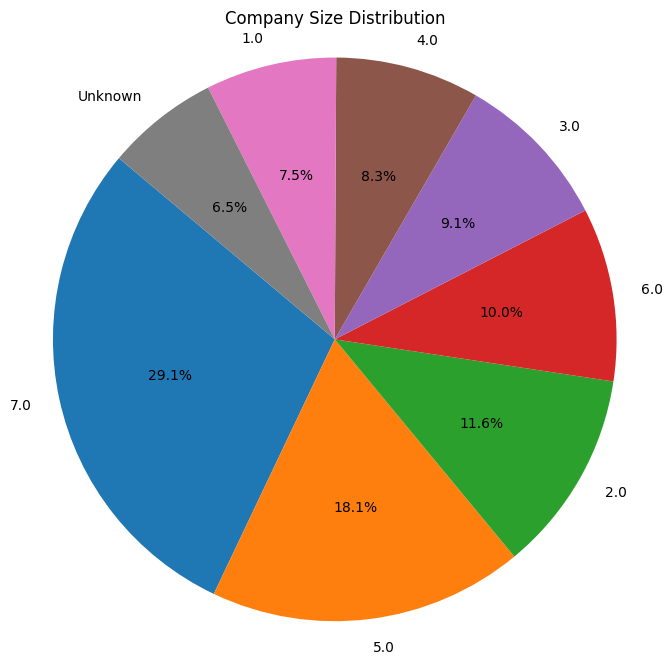

In [33]:
#Distribution of company size
company_size_counts = merged_post['company_size'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(company_size_counts, labels=company_size_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Company Size Distribution')
plt.axis('equal')
plt.show()

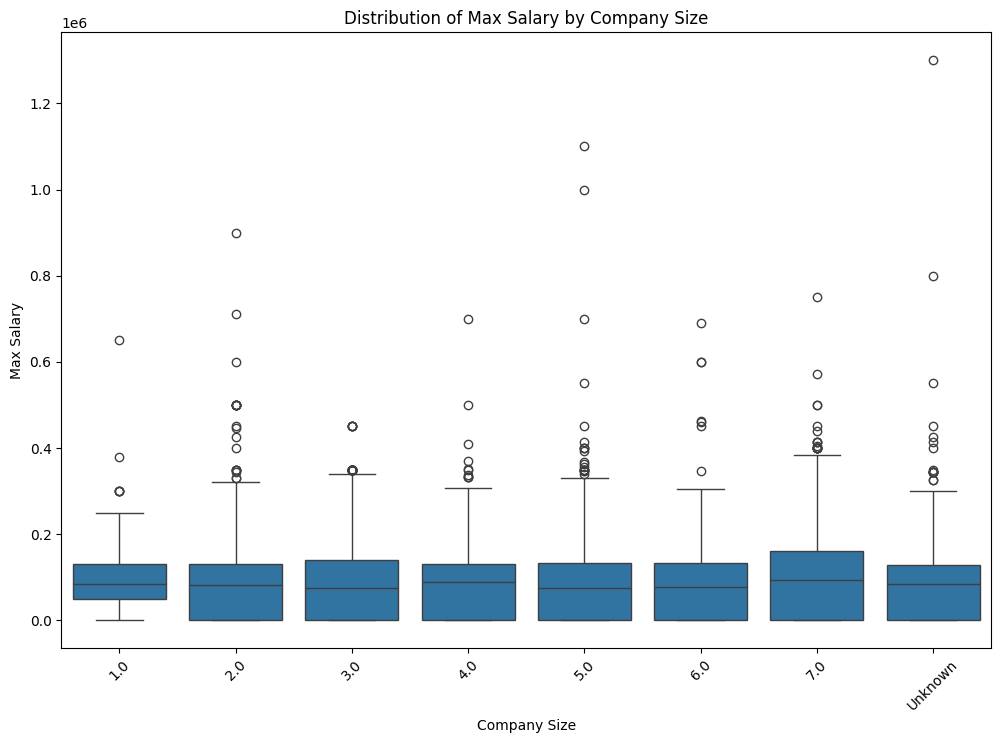

In [35]:
#Max salary by company size
plt.figure(figsize=(12, 8))
sns.boxplot(data=merged_post, x='company_size', y='max_salary',
            order=sorted(merged_post['company_size'].astype(str).unique()))
plt.title('Distribution of Max Salary by Company Size')
plt.xlabel('Company Size')
plt.ylabel('Max Salary')
plt.xticks(rotation=45)
plt.show()

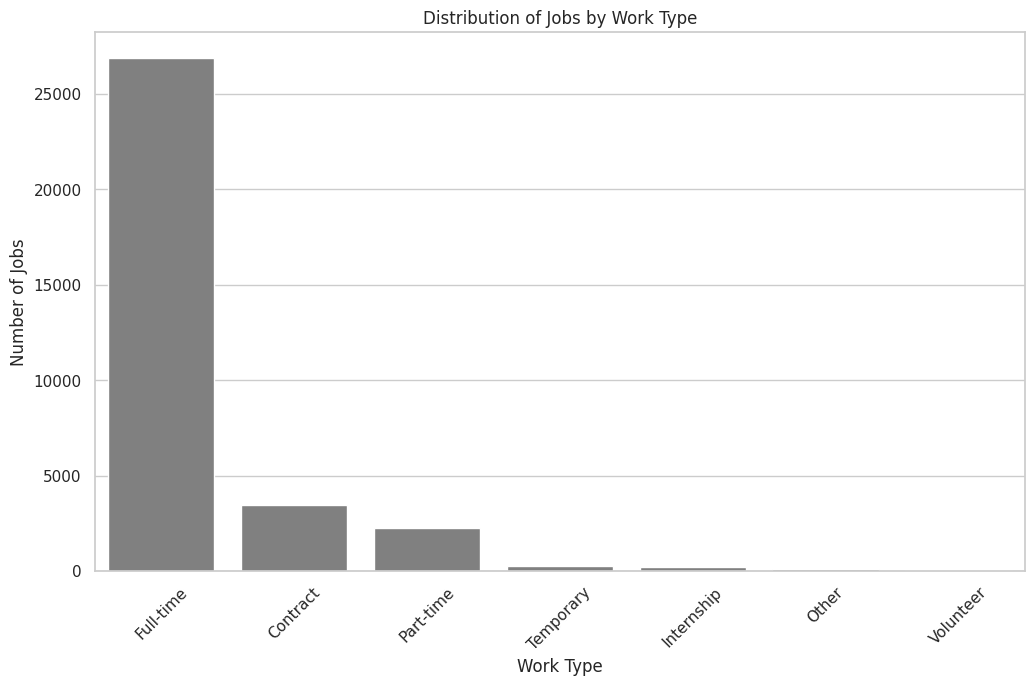

In [42]:
#Distribution of jobs by work_type
work_type_order = merged_post['formatted_work_type'].value_counts().index

plt.figure(figsize=(12, 7))
sns.countplot(data=merged_post, x='formatted_work_type', order=work_type_order, color='grey')
plt.title('Distribution of Jobs by Work Type')
plt.xlabel('Work Type')
plt.ylabel('Number of Jobs')
plt.xticks(rotation=45)
plt.show()

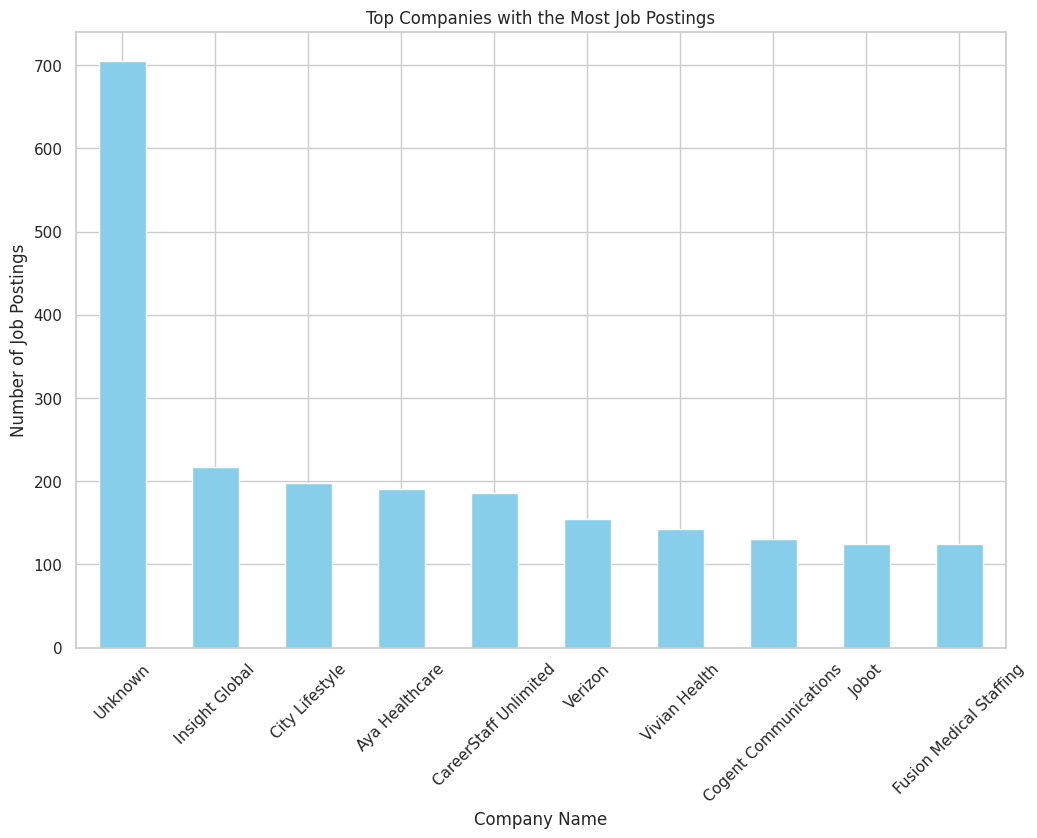

In [44]:
#Companies that post the most job openings
top_companies = merged_post['name'].value_counts().head(10)

plt.figure(figsize=(12, 8))
top_companies.plot(kind='bar', color='skyblue')
plt.title('Top Companies with the Most Job Postings')
plt.xlabel('Company Name')
plt.ylabel('Number of Job Postings')
plt.xticks(rotation=45)
plt.show()

<ipython-input-45-09ee70193481>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged_post, x='formatted_experience_level', y='med_salary', palette='viridis')


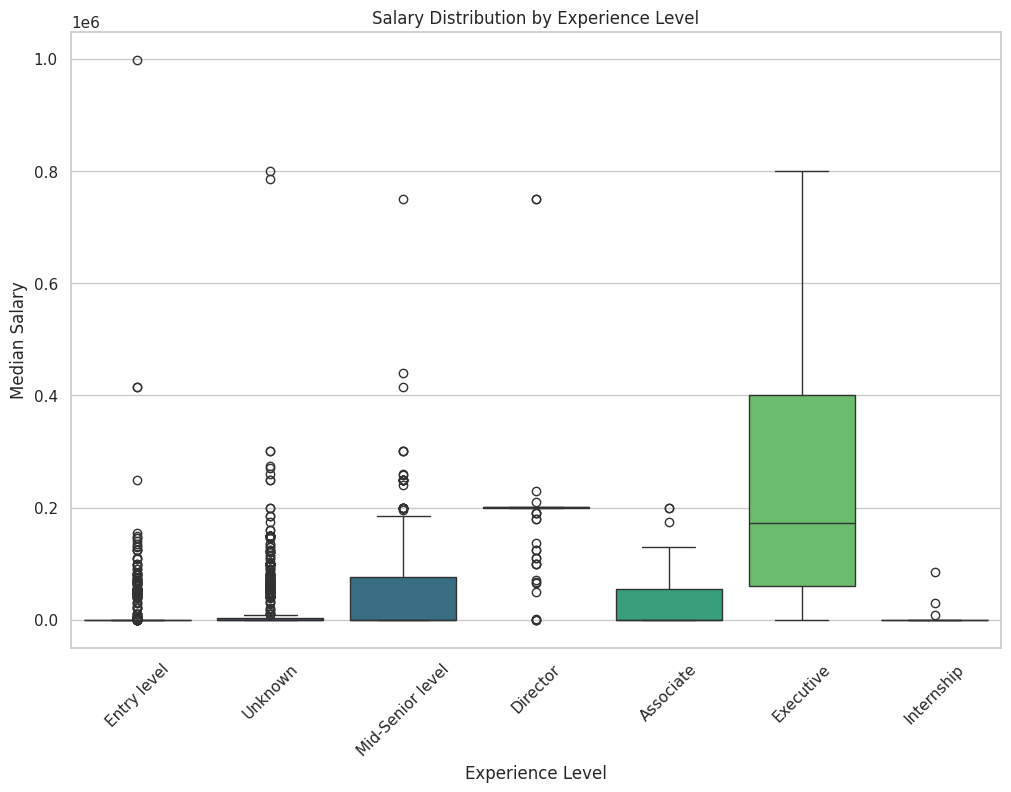

In [45]:
#Salary by experience level
sns.set(style="whitegrid")

plt.figure(figsize=(12, 8))

sns.boxplot(data=merged_post, x='formatted_experience_level', y='med_salary', palette='viridis')
plt.title('Salary Distribution by Experience Level')
plt.xlabel('Experience Level')
plt.ylabel('Median Salary')
plt.xticks(rotation=45)
plt.show()